In [4]:
# Import Dependencies
import pandas as pd

In [5]:
# Read datasets
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_train = pd.read_csv("order_products__train.csv")
order_test = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [6]:
# Merge datasets
order = order_train.merge(orders, on=['order_id'])
order = order.merge(products, on=['product_id'])
order = order.merge(aisles, on=['aisle_id'])
order_df = order.merge(departments, on=['department_id'])
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [7]:
# Remove columns not needed
order_df = order_df.drop(columns = ['eval_set', 'order_number','order_dow'], axis =1)
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [49]:
order_df.to_csv("order_df.csv")

In [52]:
# Check If There Are Repeat Customers
# Groupby User, Product ID and Product Name
top_user = order_df.groupby(['user_id','product_id','product_name']).size().reset_index(name = "count")
top_user = pd.DataFrame(top_user)

# Unique Values in Count Are 1 Meaning This Dataset is of Unique Customers
len(pd.unique(top_user['count']))

1

In [53]:
# Print Number of Aisles and Departments
print( len(pd.unique(order_df['aisle'])), len(pd.unique(order_df['department'])))

# Not many departments compare to aisles, to have our clusters be more details we'll focus on
# aisles for cluster customer segments

134 21


## Top Products in Aisle

In [84]:
# TOP Products in Aisle
top_aisle = order_df.groupby(['aisle_id','aisle','product_id','product_name']).size().reset_index(name = "count")
top_aisle = pd.DataFrame(top_aisle)
top_aisle.head()

,aisle_id,aisle,product_id,product_name,count
0,1,prepared soups salads,209,Italian Pasta Salad,8
1,1,prepared soups salads,554,Turkey Chili,56
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,1
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,5
4,1,prepared soups salads,2539,Original Potato Salad,33


In [85]:
# TOP 3 Products in Aisle
# Sort Descending on Count
top_aisle = top_aisle.sort_values(by='count', ascending = False)

# Sort Ascending on Aisle
top_aisle = top_aisle.sort_values(by='aisle_id')
top_aisle.head()

,aisle_id,aisle,product_id,product_name,count
13,1,prepared soups salads,8382,Organic Tomato Bisque,59
23,1,prepared soups salads,13029,Ready Pac Salad Santa Fe Caesar Bowls,36
44,1,prepared soups salads,20344,Chunky Chicken Noodle Soup,36
34,1,prepared soups salads,17574,American Classics Macaroni Salad,11
102,1,prepared soups salads,40788,Organic Black Bean Soup,11


In [91]:
# TOP 3 Products in Aisle (CONT.)
# Get Unique aisle_id List
unique_aisle = pd.unique(top_aisle['aisle_id'])
# Get initial dataframe to concat
inital_df = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[0]].nlargest(3, columns='count')

# Creat for loop to concat top 3 product of each aisle
for i in range(1,len(unique_aisle)):
    top_3 = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[i]].nlargest(3, columns='count')
    inital_df = pd.concat([inital_df,top_3])
    
top3_aisle = inital_df
top3_aisle.head()

,aisle_id,aisle,product_id,product_name,count
61,1,prepared soups salads,26047,Tuna Salad,208
57,1,prepared soups salads,25199,Classic Chicken Salad,200
50,1,prepared soups salads,22281,Chicken Noodle Soup,165
293,2,specialty cheeses,37524,Fresh Mozzarella Ball,450
194,2,specialty cheeses,13409,Dubliner Wedge Pre Cut Cheese,253


## Model (K-Means)

In [92]:
# Transform Table to be Percentage of Aisle Purchases For User
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [103]:
# Calculate Percentage of User
percent_user = order_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

,user_id,aisle_id,aisle,count,sum,percent
0,1,21,packaged cheese,1,11,0.090909
1,1,23,popcorn jerky,1,11,0.090909
2,1,45,candy chocolate,1,11,0.090909
3,1,53,cream,1,11,0.090909
4,1,54,paper goods,1,11,0.090909


In [104]:
# Create user product aisle percentage table
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.111111,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000


In [111]:
# Model K-means
from sklearn.cluster import KMeans

distortions = []
for k in range(1,16):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(percent_df)
    distortions.append(kmeanModel.inertia_)
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


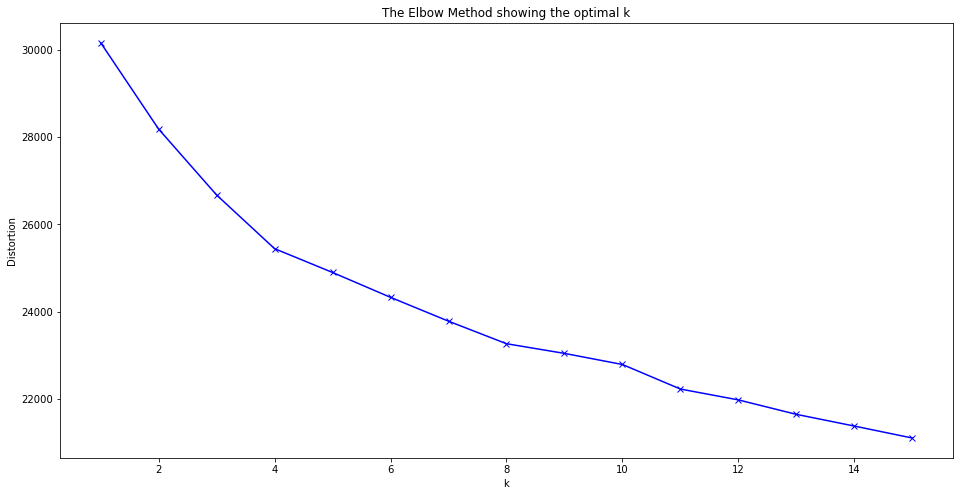

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(range(1,16), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()